In [1]:
import numpy as np
import os
import sys
import warnings
import time

# Define paths to relevant modules
measure_sampling_path = os.path.abspath(
    "/Users/rubenbontorno/Documents/Master_Thesis/Code/AWD_numerics/Measure_sampling"
)
trees_path = os.path.abspath(
    "/Users/rubenbontorno/Documents/Master_Thesis/Code/AWD_numerics/Trees"
)
Benchmark_path = os.path.abspath(
    "/Users/rubenbontorno/Documents/Master_Thesis/Code/AWD_numerics/Benchmark_value_Gausian"
)
awd_trees_path = os.path.abspath(
    "/Users/rubenbontorno/Documents/Master_Thesis/Code/AWD_numerics/AWD_trees"
)
CD_path = os.path.abspath(
    "/Users/rubenbontorno/Documents/Master_Thesis/Code/AWD_numerics/Conditional_density"
)
kmeans_meas_path = os.path.abspath(
    "/Users/rubenbontorno/Documents/Master_Thesis/Code/AWD_numerics/Adapted_empirical_measure"
)
aot_path = os.path.abspath(
    "/Users/rubenbontorno/Documents/Master_Thesis/Code/AWD_numerics/AOT_numerics"
)

# Add paths to sys.path
for path in [
    measure_sampling_path,
    trees_path,
    Benchmark_path,
    awd_trees_path,
    CD_path,
    kmeans_meas_path,
    aot_path,
]:
    if path not in sys.path:
        sys.path.append(path)

from Build_trees_from_paths import *
from Tree_Node import *
from TreeAnalysis import *
from TreeVisualization import *
from Save_Load_trees import *
from Tree_AWD_utilities import *
from Comp_AWD2_Gaussian import build_mean_and_cov, adapted_wasserstein_squared
from Gurobi_AOT import *
from Nested_Dist_Algo import compute_nested_distance
from CD_nonparam import *

from Gen_Path_and_AdaptedTrees import *
from mainfunctions import *
from measure import *
from normal_ot import *
from FVI_bench import *

from Extract_Sample_path_AOT import extract_sample_paths

# Suppress sklearn warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

from AEM_kMeans import (
    empirical_k_means_measure,
    empirical_k_means_measure_new,
    empirical_k_means_measure_grid,
)
from AEM_grid import empirical_grid_measure

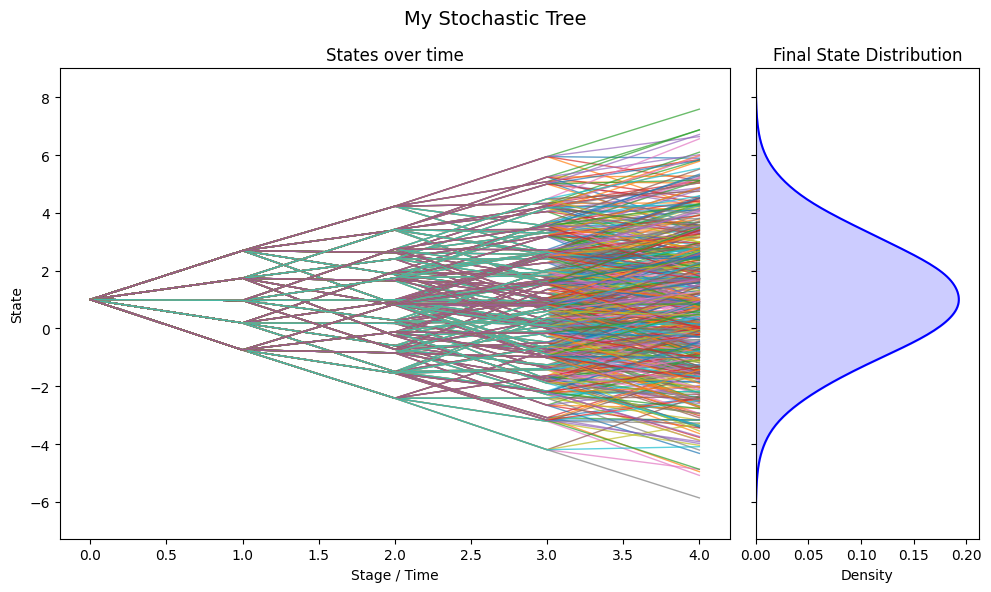

In [2]:
import numpy as np
from sklearn.cluster import KMeans


# Same mathode as in FVI code but transplated to my tree framework
def my_build_tree_binom(T, init, vol, N_leaf=2, in_size=100):
    """
    Builds a tree of depth T (i.e. T transitions, T+1 time steps) starting from init.

    At each transition, for each node in the current level, we:
      - Sample N_leaf * in_size points from N(0, vol) (as a 1D array),
      - Use KMeans clustering to obtain N_leaf cluster centers,
      - Shift these centers by the current node's value,
      - Estimate the probability of each cluster based on its relative frequency.

    The generated children are attached to the node, and the process repeats until depth T is reached.

    Parameters:
      - T (int): The number of transitions (or tree depth).
      - init (float): The initial value at the root node.
      - vol (float): The standard deviation for the Gaussian sampling.
      - N_leaf (int): The number of clusters/children per node.
      - in_size (int): The number of samples per cluster (multiplied by N_leaf) to feed into KMeans.

    Returns:
      - TreeNode: The root of the constructed tree.
    """
    # Create the root node.
    root = TreeNode(init)

    # Current level holds all nodes at the current time step.
    current_level = [root]

    # For each transition from time step t to t+1.
    for t in range(T - 1):
        next_level = []
        # For each node in the current level, generate children.
        for node in current_level:
            # Generate a bunch of random samples from a Gaussian (mean 0, std=vol).
            samples = np.random.randn(N_leaf * in_size, 1) * vol
            # Apply KMeans to get N_leaf clusters.
            kmeans = KMeans(n_clusters=N_leaf, n_init=10).fit(samples)
            # Get unique counts per cluster (to be used as probabilities).
            _, counts = np.unique(kmeans.labels_, return_counts=True)
            probs = counts / np.sum(counts)
            # Get cluster centers (they are 2D arrays, so we squeeze them).
            centers = np.squeeze(kmeans.cluster_centers_, axis=1)
            # Shift the centers by the current node's value.
            child_values = node.value + centers

            # For each child value, create a new TreeNode and add it as a child.
            for child_val, prob in zip(child_values, probs):
                child_node = TreeNode(child_val)
                node.add_child(child_node, prob)
                next_level.append(child_node)
        # Move to the next level.
        current_level = next_level

    return root


tree_root_x = my_build_tree_binom(T=5, init=1, vol=1, N_leaf=5, in_size=200)

visualize_big_tree(tree_root_x, fig_size=(10, 6), title="My Stochastic Tree")

Running simulation 1/10 for n = 2, in_size = 100...
Running simulation 2/10 for n = 2, in_size = 100...
Running simulation 3/10 for n = 2, in_size = 100...
Running simulation 4/10 for n = 2, in_size = 100...
Running simulation 5/10 for n = 2, in_size = 100...
Running simulation 6/10 for n = 2, in_size = 100...
Running simulation 7/10 for n = 2, in_size = 100...
Running simulation 8/10 for n = 2, in_size = 100...
Running simulation 9/10 for n = 2, in_size = 100...
Running simulation 10/10 for n = 2, in_size = 100...
Running simulation 1/10 for n = 3, in_size = 100...
Running simulation 2/10 for n = 3, in_size = 100...
Running simulation 3/10 for n = 3, in_size = 100...
Running simulation 4/10 for n = 3, in_size = 100...
Running simulation 5/10 for n = 3, in_size = 100...
Running simulation 6/10 for n = 3, in_size = 100...
Running simulation 7/10 for n = 3, in_size = 100...
Running simulation 8/10 for n = 3, in_size = 100...
Running simulation 9/10 for n = 3, in_size = 100...
Running sim

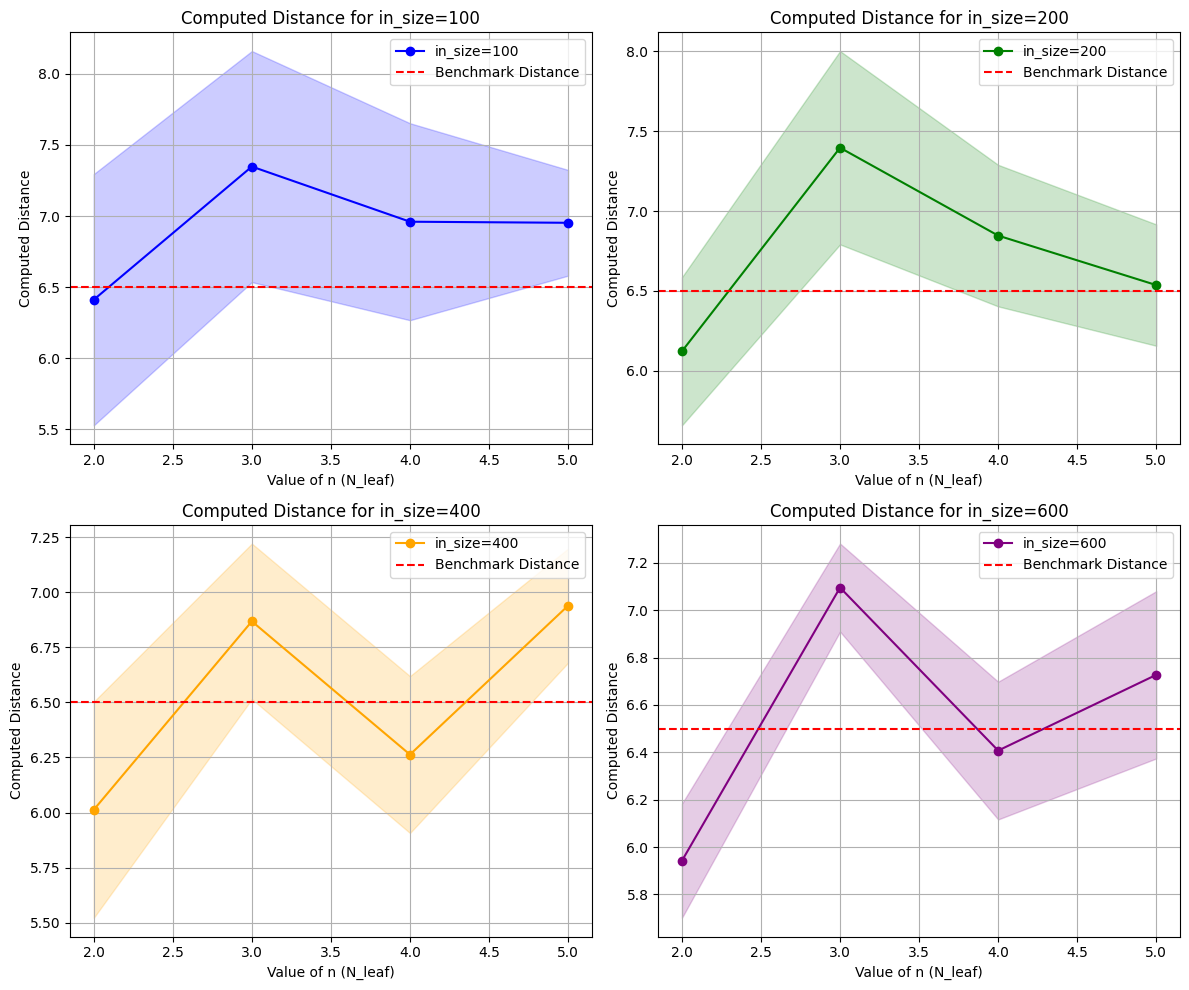

In [3]:
import random
import numpy as np
import matplotlib.pyplot as plt

# Set random seed for reproducibility
np.random.seed(12345)

# Simulation parameters
n_values = range(2, 6)
in_size_values = [100, 200, 400, 600]
num_runs = 10

a, b = 1, 2
vol_a, vol_b = 1, 0.5
var_a, var_b = vol_a**2, vol_b**2
t = 4
t_val = t

# Build mean and covariance matrices for both processes
a_vec, A_mat = build_mean_and_cov(t, mean_val=a, var_factor=var_a)
b_vec, B_mat = build_mean_and_cov(t, mean_val=b, var_factor=var_b)

# Compute adapted Wasserstein squared distance
benchmark_value = adapted_wasserstein_squared(a_vec, A_mat, b_vec, B_mat)

# Arrays to store results
results = {}

# Run simulations
for in_size in in_size_values:
    results[in_size] = np.zeros((len(n_values), num_runs))

    for i, n in enumerate(n_values):
        for run_idx in range(num_runs):
            print(
                f"Running simulation {run_idx+1}/{num_runs} for n = {n}, in_size = {in_size}..."
            )

            tree_root_x = my_build_tree_binom(
                T=t + 1, init=a, vol=vol_a, N_leaf=2, in_size=in_size
            )
            tree_root_y = my_build_tree_binom(
                T=t + 1, init=b, vol=vol_b, N_leaf=n, in_size=in_size
            )

            max_depth = get_depth(tree_root_x)

            distance_pot = compute_nested_distance(
                tree_root_x,
                tree_root_y,
                max_depth,
                method="solver_lp_pot",
                return_matrix=False,
                lambda_reg=0,
                power=2,
            )

            results[in_size][i, run_idx] = distance_pot - (a - b) ** 2


# Compute statistics
stats = {}
for in_size in in_size_values:
    distances_mean = results[in_size].mean(axis=1)
    distances_std = results[in_size].std(axis=1)
    stats[in_size] = (distances_mean, distances_std)

import matplotlib.pyplot as plt

# Create separate plots for each in_size
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Define colors for consistency
colors = ["blue", "green", "orange", "purple"]

for idx, (in_size, ax) in enumerate(zip(in_size_values, axes.flatten())):
    distances_mean, distances_std = stats[in_size]

    ax.plot(
        n_values,
        distances_mean,
        marker="o",
        color=colors[idx],
        label=f"in_size={in_size}",
    )
    ax.fill_between(
        n_values,
        distances_mean - distances_std,
        distances_mean + distances_std,
        alpha=0.2,
        color=colors[idx],
    )

    # Benchmark line
    ax.axhline(y=benchmark_value, color="r", linestyle="--", label="Benchmark Distance")

    ax.set_xlabel("Value of n (N_leaf)")
    ax.set_ylabel("Computed Distance")
    ax.set_title(f"Computed Distance for in_size={in_size}")
    ax.legend()
    ax.grid()

# Adjust layout
plt.tight_layout()
plt.show()

Running simulation 1/10 for n = 2, in_size = 100...
Running simulation 2/10 for n = 2, in_size = 100...
Running simulation 3/10 for n = 2, in_size = 100...
Running simulation 4/10 for n = 2, in_size = 100...
Running simulation 5/10 for n = 2, in_size = 100...
Running simulation 6/10 for n = 2, in_size = 100...
Running simulation 7/10 for n = 2, in_size = 100...
Running simulation 8/10 for n = 2, in_size = 100...
Running simulation 9/10 for n = 2, in_size = 100...
Running simulation 10/10 for n = 2, in_size = 100...
Running simulation 1/10 for n = 3, in_size = 100...
Running simulation 2/10 for n = 3, in_size = 100...
Running simulation 3/10 for n = 3, in_size = 100...
Running simulation 4/10 for n = 3, in_size = 100...
Running simulation 5/10 for n = 3, in_size = 100...
Running simulation 6/10 for n = 3, in_size = 100...
Running simulation 7/10 for n = 3, in_size = 100...
Running simulation 8/10 for n = 3, in_size = 100...
Running simulation 9/10 for n = 3, in_size = 100...
Running sim

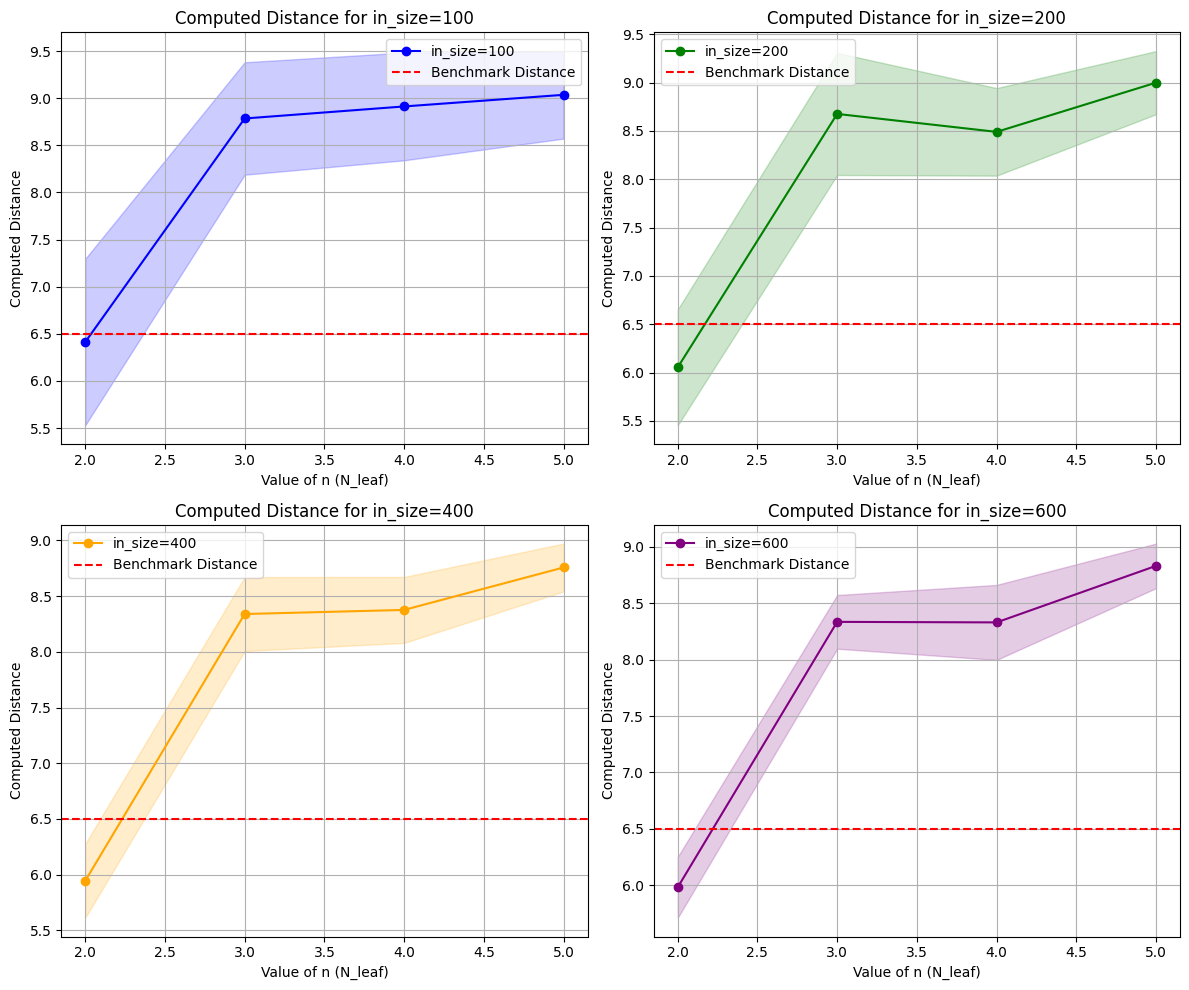

In [4]:
import random
import numpy as np
import matplotlib.pyplot as plt

# Set random seed for reproducibility
np.random.seed(12345)

# Simulation parameters
n_values = range(2, 6)
in_size_values = [100, 200, 400, 600]
num_runs = 10

a, b = 1, 2
vol_a, vol_b = 1, 0.5
var_a, var_b = vol_a**2, vol_b**2
t = 4
t_val = t

# Build mean and covariance matrices for both processes
a_vec, A_mat = build_mean_and_cov(t, mean_val=a, var_factor=var_a)
b_vec, B_mat = build_mean_and_cov(t, mean_val=b, var_factor=var_b)

# Compute adapted Wasserstein squared distance
benchmark_value = adapted_wasserstein_squared(a_vec, A_mat, b_vec, B_mat)

# Arrays to store results
results = {}

# Run simulations
for in_size in in_size_values:
    results[in_size] = np.zeros((len(n_values), num_runs))

    for i, n in enumerate(n_values):
        for run_idx in range(num_runs):
            print(
                f"Running simulation {run_idx+1}/{num_runs} for n = {n}, in_size = {in_size}..."
            )

            tree_root_x = my_build_tree_binom(
                T=t + 1, init=a, vol=vol_a, N_leaf=n, in_size=in_size
            )
            tree_root_y = my_build_tree_binom(
                T=t + 1, init=b, vol=vol_b, N_leaf=2, in_size=in_size
            )

            max_depth = get_depth(tree_root_x)

            distance_pot = compute_nested_distance(
                tree_root_x,
                tree_root_y,
                max_depth,
                method="solver_lp_pot",
                return_matrix=False,
                lambda_reg=0,
                power=2,
            )

            results[in_size][i, run_idx] = distance_pot - (a - b) ** 2


# Compute statistics
stats = {}
for in_size in in_size_values:
    distances_mean = results[in_size].mean(axis=1)
    distances_std = results[in_size].std(axis=1)
    stats[in_size] = (distances_mean, distances_std)

import matplotlib.pyplot as plt

# Create separate plots for each in_size
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Define colors for consistency
colors = ["blue", "green", "orange", "purple"]

for idx, (in_size, ax) in enumerate(zip(in_size_values, axes.flatten())):
    distances_mean, distances_std = stats[in_size]

    ax.plot(
        n_values,
        distances_mean,
        marker="o",
        color=colors[idx],
        label=f"in_size={in_size}",
    )
    ax.fill_between(
        n_values,
        distances_mean - distances_std,
        distances_mean + distances_std,
        alpha=0.2,
        color=colors[idx],
    )

    # Benchmark line
    ax.axhline(y=benchmark_value, color="r", linestyle="--", label="Benchmark Distance")

    ax.set_xlabel("Value of n (N_leaf)")
    ax.set_ylabel("Computed Distance")
    ax.set_title(f"Computed Distance for in_size={in_size}")
    ax.legend()
    ax.grid()

# Adjust layout
plt.tight_layout()
plt.show()